In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
sys.path.insert(0, '../scripts')
from l5kit_modified.l5kit_modified import FramesDataset, create_chopped_dataset, AgentDatasetModified, get_agent_indices_set
from kalman import KalmanTrackerPredictor
from lane_processing import *
import pickle
from l5kit.evaluation import write_pred_csv, compute_metrics_csv
from l5kit.evaluation.metrics import neg_multi_log_likelihood
from l5kit.data import LocalDataManager, ChunkedDataset
from pathlib import Path
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

from pytz import timezone
from datetime import datetime, timedelta
from l5kit.data.filter import filter_tl_faces_by_status
from workalendar.usa import CaliforniaSanFrancisco
import pandas as pd
import json
from django.core.serializers.json import DjangoJSONEncoder

from collections import defaultdict
import gc
import multiprocessing as mp
import tracemalloc
import linecache
from functools import partial
tracemalloc.start()

def display_top(snapshot, key_type='lineno', limit=20):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    top_stats = snapshot.statistics(key_type)

    print("Top %s lines" % limit)
    for index, stat in enumerate(top_stats[:limit], 1):
        frame = stat.traceback[0]
        # replace "/path/to/module/file.py" with "module/file.py"
        filename = os.sep.join(frame.filename.split(os.sep)[-2:])
        print("#%s: %s:%s: %.1f KiB"
              % (index, filename, frame.lineno, stat.size / 1024))
        line = linecache.getline(frame.filename, frame.lineno).strip()
        if line:
            print('    %s' % line)

    other = top_stats[limit:]
    if other:
        size = sum(stat.size for stat in other)
        print("%s other: %.1f KiB" % (len(other), size / 1024))
    total = sum(stat.size for stat in top_stats)
    print("Total allocated size: %.1f KiB" % (total / 1024))






snapshot = tracemalloc.take_snapshot()
display_top(snapshot)

%matplotlib inline
    
os.environ["L5KIT_DATA_FOLDER"] = "../input/"

Top 20 lines
#1: python3.7/codeop.py:141: 7.2 KiB
    codeob = compile(source, filename, symbol, self.flags, 1)
#2: <ipython-input-1-7ecc8e3d0a3c>:65: 0.4 KiB
    snapshot = tracemalloc.take_snapshot()
#3: core/interactiveshell.py:3417: 0.4 KiB
    exec(code_obj, self.user_global_ns, self.user_ns)
#4: <ipython-input-1-7ecc8e3d0a3c>:35: 0.1 KiB
    def display_top(snapshot, key_type='lineno', limit=20):
#5: core/interactiveshell.py:3337: 0.1 KiB
    if (await self.run_code(code, result,  async_=asy)):
#6: core/interactiveshell.py:117: 0.1 KiB
    Module = lambda nodelist, type_ignores: OriginalModule(nodelist)
#7: core/compilerop.py:150: 0.0 KiB
    self.flags &= ~turn_on_bits
#8: core/interactiveshell.py:3331: 0.0 KiB
    mod = Module([node], [])
Total allocated size: 8.4 KiB


In [2]:
FILTER_AGENTS_THRESHOLD = 0.5
NUM_FRAMES_TO_CHOP = 100
FUTURE_NUM_FRAMES = 50
MIN_FUTURE_STEPS = 10
BATCH_SIZE = 256
dm = LocalDataManager(None)

# dataset_path = 'scenes/sample.zarr'
dataset_path = 'scenes/train.zarr'
# dataset_path = 'scenes/test.zarr'
# eval_mask = np.load(os.path.join(f"{os.environ['L5KIT_DATA_FOLDER']}",
#                                          "scenes/mask.npz"))["arr_0"]
eval_zarr = ChunkedDataset(dm.require(dataset_path)).open(cached=False)


# eval_base_path = create_chopped_dataset(dm.require(dataset_path),
#                                                      FILTER_AGENTS_THRESHOLD,
#                                                      NUM_FRAMES_TO_CHOP,
#                                                      FUTURE_NUM_FRAMES,
#                                                      MIN_FUTURE_STEPS,
#                                        include_gt=True)
# eval_gt_path = os.path.join(eval_base_path, 'gt.csv')

# eval_zarr_path = str(Path(eval_base_path) / Path(dm.require(dataset_path)).name)
# eval_mask_path = str(Path(eval_base_path) / "mask.npz")
# eval_mask = np.load(eval_mask_path)["arr_0"]
# eval_zarr = ChunkedDataset(eval_zarr_path).open()

In [3]:
# root_group = zarr.open_group(dm.require(dataset_path), mode='r')
# frames = root_group[FRAME_ARRAY_KEY]
# agents = root_group[AGENT_ARRAY_KEY]
# scenes = root_group[SCENE_ARRAY_KEY]
# tl_faces = root_group[TL_FACE_ARRAY_KEY]
# frames['ego_rotation'][10000]
# del frames, agents, scenes, tl_faces, root_group
# gc.collect()

In [4]:
semantic_map_path = dm.require(semantic_map_key)
proto_API = MapAPI(semantic_map_path, world_to_ecef)

In [5]:
lanes_crosswalks = precompute_map_elements(proto_API)
lane_id_2_idx = {lane_id: i for i, lane_id in enumerate(lanes_crosswalks['lanes']['ids'])}
lane_adj_list_forward, lane_adj_list_backward, lane_adj_list_right, lane_adj_list_left = precompute_lane_adjacencies(lane_id_2_idx, proto_API)
all_center_coords = np.concatenate(lanes_crosswalks['lanes']['center_line'], axis=0)
kd_tree = KDTree(all_center_coords)

kd_idx_2_lane_id_idx = []
for lane_id, center_line in zip(lanes_crosswalks['lanes']['ids'],
                                lanes_crosswalks['lanes']['center_line']):
    next_entries = [(lane_id, i) for i in range(len(center_line))]
    kd_idx_2_lane_id_idx.extend(next_entries)

In [6]:
# i = 0
# traffic_light_control_id_2_lane_id = dict()
# lane_id_2_traffic_light_control_id = dict()
# for lane_id in lanes_crosswalks['lanes']['ids']:
#     traffic_light_controls = proto_API.get_lane_traffic_controls(lane_id)
#     if len(traffic_light_controls):
#         i += 1
#         for traffic_light_el in traffic_light_controls:
#             traffic_light_id = proto_API.id_as_str(traffic_light_el)
#             if traffic_light_id not in traffic_light_control_id_2_lane_id:
#                 traffic_light_control_id_2_lane_id[traffic_light_id] = {lane_id}
#             else:
#                 traffic_light_control_id_2_lane_id[traffic_light_id].add(lane_id)
                
#             if lane_id not in lane_id_2_traffic_light_control_id:
#                 lane_id_2_traffic_light_control_id[lane_id] = {traffic_light_id}
#             else:
#                 lane_id_2_traffic_light_control_id[lane_id].add(traffic_light_id)
# i / len(lanes_crosswalks['lanes']['ids'])

In [7]:
# for element in tqdm(proto_API):
#     traffic_light_id = MapAPI.id_as_str(element.id)
#     if proto_API.is_traffic_control_element(traffic_light_id):
#         traffic_light_face_set = proto_API.get_traffic_light_face_sets(traffic_light_id)
        
#         for yield_set, _ in traffic_light_face_set:
#             lanes_paying_attention = [MapAPI.id_as_str(x['lane']) for x in proto_API.get_rules_for_traffic_light_face_set(yield_set)]
#             for lane_id in lanes_paying_attention:
#                 if traffic_light_id not in traffic_light_control_id_2_lane_id:
#                     print('new traffic light', yield_set)
#                     traffic_light_control_id_2_lane_id_[traffic_light_id] = {lane_id}
#                 else:
#                     if lane_id not in traffic_light_control_id_2_lane_id[traffic_light_id]:
#                         print('additional light id')
#                         traffic_light_control_id_2_lane_id[traffic_light_id].add(lane_id)

In [8]:
# traffic_light_ids_all = set(eval_zarr.tl_faces['traffic_light_id'])
# with open('traffic_light_ids_all.pkl', 'wb') as f:
#     pickle.dump(traffic_light_ids_all, f)
with open('traffic_light_ids_all.pkl', 'rb') as f:
    traffic_light_ids_all = pickle.load(f)

In [9]:
# snapshot = tracemalloc.take_snapshot()

In [10]:
# display_top(snapshot)

In [11]:
# import zarr
# FRAME_ARRAY_KEY = "frames"
# AGENT_ARRAY_KEY = "agents"
# SCENE_ARRAY_KEY = "scenes"
# TL_FACE_ARRAY_KEY = "traffic_light_faces"


# root_group = zarr.open_group(dm.require(dataset_path), mode='r')
# frames = root_group[FRAME_ARRAY_KEY]
# agents = root_group[AGENT_ARRAY_KEY]
# scenes = root_group[SCENE_ARRAY_KEY]
# tl_faces = root_group[TL_FACE_ARRAY_KEY]
# frames['ego_rotation'][0]

In [12]:
traffic_light_control_id_2_lane_id = defaultdict(set)
lane_id_2_traffic_light_control_id = defaultdict(set)

tl_face_id_2_lane_id = defaultdict(set)
lane_id_2_tl_face_id = defaultdict(set)
for lane_id in lanes_crosswalks['lanes']['ids']:
    traffic_light_controls = proto_API.get_lane_traffic_controls(lane_id)
    if len(traffic_light_controls):
        for traffic_light_el in traffic_light_controls:
            traffic_light_id = proto_API.id_as_str(traffic_light_el)
            if traffic_light_id in traffic_light_ids_all:
                traffic_light_control_id_2_lane_id[traffic_light_id].add(lane_id)
                lane_id_2_traffic_light_control_id[lane_id].add(traffic_light_id)
            else:
                tl_face_id_2_lane_id[traffic_light_id].add(lane_id)
                lane_id_2_tl_face_id[lane_id].add(traffic_light_id)
                

In [13]:
def get_traffic_light_coordinates(tl_el_id):
    if el_id in proto_API.ids_to_el:
        coordinates = proto_API.get_traffic_light_coords(el_id)['xyz']
        return coordinates[:, :2].mean(axis=0)

In [14]:
traffic_light_id_2_coord = dict()

for el_id in traffic_light_ids_all:
    if el_id in proto_API.ids_to_el:
        coordinates = proto_API.get_traffic_light_coords(el_id)['xyz']
        traffic_light_id_2_coord[el_id] = coordinates[:, :2].mean(axis=0)

In [15]:
def collate_fn_lane_seq(data_batch, out_of_lane_threshold=2.5):
    history_result_list = []
    for batch_el in data_batch:
        init_ts = datetime.fromtimestamp(batch_el['timestamp']/10**9).astimezone(timezone('US/Pacific')) - timedelta(milliseconds=100)

        track_id_2_lanes = defaultdict(list)
        for hist_i in range(0, len(batch_el['history_agents']), 10):
            for car_agent in batch_el['history_agents'][hist_i]:
                if np.nonzero(car_agent[-1])[0][0] == 3:
                    track_id = car_agent[-2]
                    agent_centroid = car_agent[0]
                    lane_dist, kd_idx = kd_tree.query(agent_centroid, k=1)
                    if lane_dist <= out_of_lane_threshold:
                        lane_id, lane_point_i = kd_idx_2_lane_id_idx[kd_idx]
                        
                        if track_id not in track_id_2_lanes or track_id_2_lanes[track_id][-1] != lane_id:
                            track_id_2_lanes[track_id].append(lane_id)
        
        # post-process
#         prev_ts = init_ts
        # prev_ts -= timedelta(milliseconds=200)
        for track_id, lanes in track_id_2_lanes.items():
            
            if len(lanes):
                history_result_list.append((track_id, lanes))
    
    return history_result_list

In [16]:
def collate_fn_lane_seq(data_batch, out_of_lane_threshold=2.5):
    history_result_list = []
    for batch_el in data_batch:
        init_ts = datetime.fromtimestamp(batch_el['timestamp']/10**9).astimezone(timezone('US/Pacific')) - timedelta(milliseconds=100)

        car_2_lane_speed = defaultdict(list)
        lane_2_hist_i_2_speeds = dict()
        for hist_i in range(0, len(batch_el['history_agents']), 10):
            car_agents = [agent for agent in batch_el['history_agents'][hist_i] if np.nonzero(agent[-1])[0][0] == 3]
            for car_agent in car_agents:
                track_id = car_agent[-2]
                agent_speed = np.hypot(*car_agent[-3])
                agent_centroid = car_agent[0]
                lane_dist, kd_idx = kd_tree.query(agent_centroid, k=1)
                if lane_dist <= out_of_lane_threshold:
                    lane_id, lane_point_i = kd_idx_2_lane_id_idx[kd_idx]
                    lane_completion = lane_point_i/len(lanes_crosswalks['lanes']['center_line'][lane_id_2_idx[lane_id]])
                    car_2_lane_speed[track_id].append((lane_id, lane_completion, agent_speed))
                    if lane_id not in lane_2_hist_i_2_speeds:
                        lane_2_hist_i_2_speeds[lane_id] = defaultdict(list)
                    lane_2_hist_i_2_speeds[lane_id][hist_i].append(agent_speed)
        
        # post-process
#         prev_ts = init_ts
        # prev_ts -= timedelta(milliseconds=200)
        track_id_2_hist = dict()
        for track_id, lane_speed_vals in car_2_lane_speed.items():
            track_id_seq = []
            prev_lane_id = -999
            for hist_j, lane_speed in enumerate(lane_speed_vals):
                lane_id, lane_completion, speed = lane_speed
                if lane_id != prev_lane_id:
                    if prev_lane_id != -999:
                        prev_lane_this_car_mean_speed = np.mean(prev_lane_this_car_speeds)
                        prev_lane_this_car_std_speed = np.std(prev_lane_this_car_speeds)
                        prev_lane_all_cars_mean_speed = np.mean(prev_lane_all_speeds)
                        prev_lane_all_cars_std_speed = np.std(prev_lane_all_speeds)
                        track_id_seq.append((prev_lane_id, prev_lane_completion_at_start, len(prev_lane_this_car_speeds), prev_lane_this_car_mean_speed, prev_lane_this_car_std_speed, len(prev_lane_all_speeds), prev_lane_all_cars_mean_speed, prev_lane_all_cars_std_speed))

                    prev_lane_this_car_speeds = [speed]
                    prev_lane_all_speeds = lane_2_hist_i_2_speeds[lane_id][hist_j]
                    prev_lane_id = lane_id
                    prev_lane_completion_at_start = lane_completion
                else:
                    prev_lane_this_car_speeds.append(speed)
                    prev_lane_all_speeds.extend(lane_2_hist_i_2_speeds[lane_id][hist_j])
            if len(track_id_seq):
                track_id_2_hist[track_id] = track_id_seq
                
        track_id_2_lanes = defaultdict(list)
        for hist_i in range(0, len(batch_el['history_agents']), 10):
            for car_agent in batch_el['history_agents'][hist_i]:
                if np.nonzero(car_agent[-1])[0][0] == 3:
                    track_id = car_agent[-2]
                    if track_id in track_id_2_hist:
                        agent_centroid = car_agent[0]
                        lane_dist, kd_idx = kd_tree.query(agent_centroid, k=1)
                        if lane_dist <= out_of_lane_threshold:
                            lane_id, lane_point_i = kd_idx_2_lane_id_idx[kd_idx]

                            if track_id not in track_id_2_lanes or track_id_2_lanes[track_id][-1] != lane_id:
                                track_id_2_lanes[track_id].append(lane_id)
        
        # post-process
#         prev_ts = init_ts
        # prev_ts -= timedelta(milliseconds=200)
        for track_id, future_lanes in track_id_2_lanes.items():            
            if len(future_lanes):
                history_result_list.append((track_id, track_id_2_hist[track_id], future_lanes))
    
    return history_result_list

# ==================

In [17]:
# cfg = {"model_params": {"history_num_frames": 100,
#                                     "history_step_size": 1,
#                                     "future_num_frames": 50,
#                                     "future_step_size": 1},
#                    "raster_params": {"filter_agents_threshold": FILTER_AGENTS_THRESHOLD}}
# dataset = AgentDatasetModified(cfg, eval_zarr) #, agents_mask=eval_mask) #, offset_targets=False)
    
# dataloader = DataLoader(dataset, shuffle=False, batch_size=1024,
#                         num_workers=1,
#                         collate_fn=lambda x: x) #[el['history_agents'] for el in x])#collate_fn_traffic_lights2)

In [18]:
agent_indices_set = get_agent_indices_set(eval_zarr, filter_agents_threshold=0.5)

In [19]:
dataset = FramesDataset(eval_zarr, with_history=True, agent_indices_set=agent_indices_set) #, agents_mask=eval_mask) #, offset_targets=False)
    
dataloader = DataLoader(dataset, shuffle=False, batch_size=512,
                        num_workers=16,
                        collate_fn=collate_fn_lane_seq) #[el['history_agents'] for el in x])#collate_fn_traffic_lights2)

In [20]:
# data_iter = iter(dataloader)

In [21]:
# data_batch = next(data_iter)
# len(data_batch)

In [22]:
# data_batch[0]

In [ ]:
count_of_single_len_seq = 0

track_id_list = []
hist_seq_list = []
future_seq_list = []

for data_batch in tqdm(dataloader):
    for data_sample in data_batch:
        track_id, hist_seq, future_seq = data_sample 

        track_id_list.append(track_id)
        hist_seq_list.append(hist_seq)
        future_seq_list.append(future_seq)

In [26]:
[len(x) for x in [track_id_list, hist_seq_list, future_seq_list]]

[6702765, 6702765, 6702765]

In [28]:
lane_seq_df = pd.DataFrame({'track_id': track_id_list, 
                                  'hist_seq': hist_seq_list,
                                  'future_seq': future_seq_list})
# lane_seq_df.to_hdf('../input/lane_seq_df.hdf5', key='data')

In [33]:
lane_seq_df['hist_seq'] = lane_seq_df['hist_seq'].map(tuple)
lane_seq_df['future_seq'] = lane_seq_df['future_seq'].map(tuple)

In [34]:
lane_seq_df.drop_duplicates(inplace=True)
len(lane_seq_df)

6696366

In [35]:
lane_seq_df.to_hdf('../input/lane_seq_df.hdf5', key='data')

In [36]:
pd.set_option('display.max_colwidth', 500)
lane_seq_df.head()

,track_id,hist_seq,future_seq
0,328,"((bUGp, 0.2222222222222222, 2, 22.188255, 0.033309937, 0, nan, nan), (sRCY, 0.4444444444444444, 1, 22.307493, 0.0, 0, nan, nan))","(bUGp, sRCY, O5jj)"
1,328,"((bUGp, 0.2222222222222222, 2, 22.188255, 0.033309937, 0, nan, nan), (sRCY, 0.4444444444444444, 1, 22.307493, 0.0, 0, nan, nan), (O5jj, 0.7692307692307693, 2, 22.45031, 0.04981613, 0, nan, nan))","(bUGp, sRCY, O5jj, sRCY)"
2,328,"((bUGp, 0.2222222222222222, 2, 22.188255, 0.033309937, 0, nan, nan), (sRCY, 0.4444444444444444, 1, 22.307493, 0.0, 0, nan, nan), (O5jj, 0.7692307692307693, 2, 22.45031, 0.04981613, 0, nan, nan))","(bUGp, sRCY, O5jj, sRCY)"
3,328,"((bUGp, 0.2222222222222222, 2, 22.188255, 0.033309937, 0, nan, nan), (sRCY, 0.4444444444444444, 1, 22.307493, 0.0, 0, nan, nan), (O5jj, 0.7692307692307693, 2, 22.45031, 0.04981613, 0, nan, nan))","(bUGp, sRCY, O5jj, sRCY)"
4,328,"((bUGp, 0.2222222222222222, 2, 22.188255, 0.033309937, 0, nan, nan), (sRCY, 0.4444444444444444, 1, 22.307493, 0.0, 0, nan, nan), (O5jj, 0.7692307692307693, 2, 22.45031, 0.04981613, 0, nan, nan))","(bUGp, sRCY, O5jj, sRCY)"


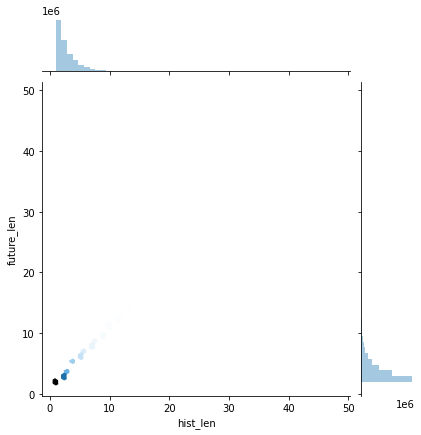

In [37]:
lane_seq_df['hist_len']  = lane_seq_df['hist_seq'].map(len)
lane_seq_df['future_len']  = lane_seq_df['future_seq'].map(len)
sns.jointplot(data=lane_seq_df, x="hist_len", y="future_len", kind="hex")